# Code along 4

## Scale, Standardize, or Normalize with scikit-learn
### När ska man använda MinMaxScaler, RobustScaler, StandardScaler, och Normalizer
### Attribution: Jeff Hale

### Varför är det ofta nödvändigt att genomföra så kallad variable transformation/feature scaling det vill säga, standardisera, normalisera eller på andra sätt ändra skalan på data vid dataaalys?

Som jag gått igenom på föreläsningen om data wrangling kan data behöva formateras (variable transformation) för att förbättra prestandan hos många algoritmer för dataanalys. En typ av formaterinng av data, som går att göra på många olika sätt, är så kallad skalning av attribut (feature scaling). Det kan finnas flera anledningar till att data kan behöv skalas, några exempel är:

* Exempelvis neurala nätverk, regressionsalgoritmer och K-nearest neighbors fungerar inte lika bra om inte de attribut (features) som algoritmen använder befinner sig i relativt lika skalor. 

* Vissa av metoderna för att skala, standardisera och normalisera kan också minska den negativa påverkan outliers kan ha i vissa algoritmer.

* Ibland är det också av vikt att ha data som är normalfördelat.

*Med skala menas inte den skala som hänsyftas på exempelvis kartor där det brukar anges att skalan är 1:50 000 vilket tolkas som att varje avstånd på kartan är 50 000 ggr kortare än i verkligheten.* 


In [1]:
#Importerar de bibliotek vi behöver
import numpy as np 
import pandas as pd 
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
#Denna kod sätter upp hur matplotlib ska visa grafer och plotar
%matplotlib inline
matplotlib.style.use('ggplot')

#Generera lite input 
#(den som är extremt intresserad kan läsa följande, intressanta och roliga förklaring kring varför random.seed egentligen är pseudorandom)
#https://www.sharpsightlabs.com/blog/numpy-random-seed/
np.random.seed(34)

# Original Distributions 

Data som det kan se ut i original, alltså när det samlats in, innan någon pre-processing har genomförts.

För att ha data att använda i övningarna skapar nedanstående kod ett antal randomiserade spridningar av data

In [2]:
#skapa kolumner med olika fördelningar 
df = pd.DataFrame({ 
    'beta': np.random.beta(5, 1, 1000) * 60,        # beta
    'exponential': np.random.exponential(10, 1000), # exponential
    'normal_p': np.random.normal(10, 2, 1000),      # normal platykurtic
    'normal_l': np.random.normal(10, 10, 1000),     # normal leptokurtic
})

# make bimodal distribution
first_half = np.random.normal(20, 3, 500) 
second_half = np.random.normal(-20, 3, 500) 
bimodal = np.concatenate([first_half, second_half])

df['bimodal'] = bimodal

# create list of column names to use later
col_names = list(df.columns)

## Exempel 1: 

a. Plotta de kurvor som skapats i ovanstående cell i en och samma koordinatsystem med hjälp av [seaborn biblioteket](https://seaborn.pydata.org/api.html#distribution-api).

>Se till att det är tydligt vilken kurva som representerar vilken distribution.
>


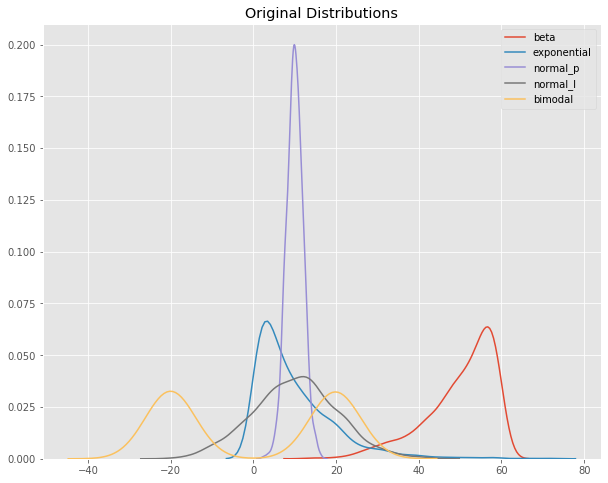

In [3]:
# plot original distribution plot
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

#De fem kurvorna
sns.kdeplot(df['beta'], ax=ax1)
sns.kdeplot(df['exponential'], ax=ax1)
sns.kdeplot(df['normal_p'], ax=ax1)
sns.kdeplot(df['normal_l'], ax=ax1)
sns.kdeplot(df['bimodal'], ax=ax1);

b. Visa de fem första raderna i den dataframe som innehåller alla distributioner.

In [4]:
df.head()

,beta,exponential,normal_p,normal_l,bimodal
0,39.273740,2.263890,11.860245,4.748207,19.496627
1,55.030395,13.108592,11.796582,10.959172,16.871186
2,47.434682,3.312019,11.146945,3.919227,12.655741
3,43.173536,17.664301,8.266689,42.072915,18.657904
4,45.681443,2.109760,5.112983,16.960664,22.646439


c. För samtliga fem attribut, beräkna:

* medel
* median

Vad för bra metod kan användas för att få ett antal statistiska mått på en dataframe? Hämta denna information med denna metod.

In [5]:
df.describe()

,beta,exponential,normal_p,normal_l,bimodal
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,50.024249,10.028387,9.994006,10.175745,-0.076622
std,8.474545,9.733928,2.013971,10.104004,20.165208
min,13.854022,0.007617,2.356844,-19.539980,-28.709856
25%,45.793283,2.951421,8.687478,3.566822,-19.995311
50%,52.337504,7.018565,9.983498,10.326331,0.237049
75%,56.722191,14.022485,11.306914,16.615057,19.891202
max,59.990640,71.344341,16.214364,42.072915,28.252151


d. I pandas kan du plotta din dataframe på några olika sätt. Gör en plot för att ta reda på hur skalan på de olika attibuten ser ut, befinner sig alla fem i ungefär samma skala?


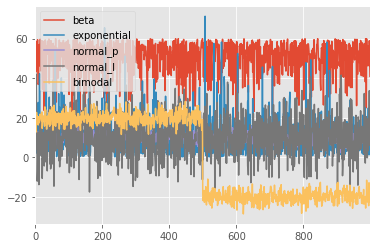

In [6]:
df.plot()

* Samtliga värden ligger inom liknande intervall

e. Vad händer om följande kolumn med randomiserade värden läggs till?

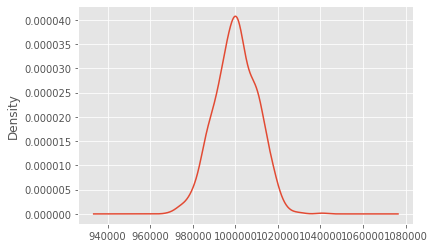

In [7]:
new_column = np.random.normal(1000000, 10000, (1000,1))
df['new_column'] = new_column
col_names.append('new_column')
df['new_column'].plot(kind='kde')

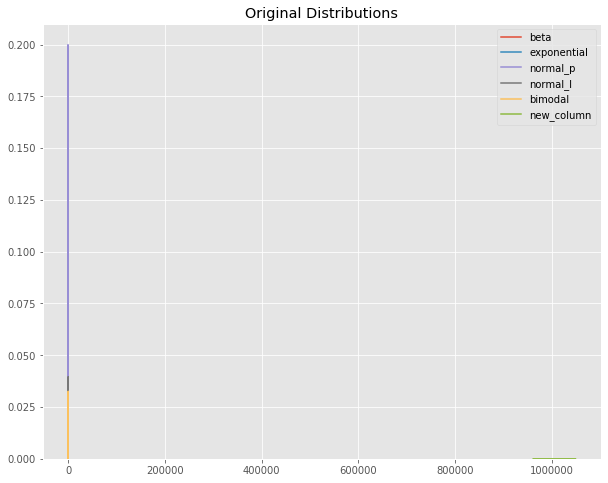

In [8]:
# plotta våra originalvärden tillsammans med det nya värdet
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

sns.kdeplot(df['beta'], ax=ax1)
sns.kdeplot(df['exponential'], ax=ax1)
sns.kdeplot(df['normal_p'], ax=ax1)
sns.kdeplot(df['normal_l'], ax=ax1)
sns.kdeplot(df['bimodal'], ax=ax1);
sns.kdeplot(df['new_column'], ax=ax1);

Hur gick det?

### MinMaxScaler

MinMaxScaler subtraherar varje värde i en kolumn med medelvärdet av den kolumnen och dividerar sedan med antalet värden. Passar ofta bra när standard scaler är olämpligt att använda, exempelvis om data inte är normalfördelat (Gausiian) eller om standardavvikelsen är väldigt liten i originaldata. Dock känslig för outliers och passar därför inte när det finns många outliers (då är ofta robust scaler bra istället). MinMax scaler rår generellt inte på skevhet. 


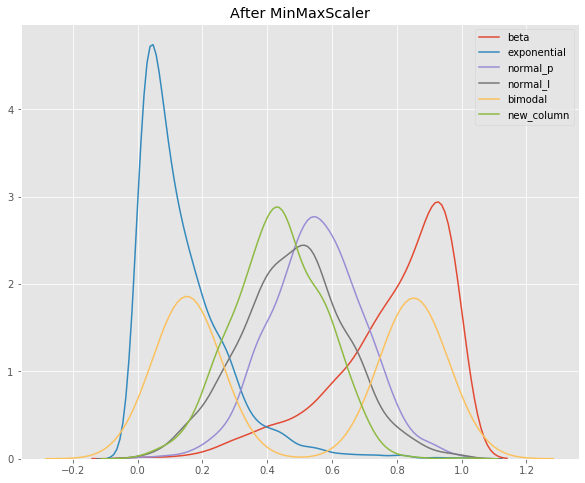

In [9]:
mm_scaler = preprocessing.MinMaxScaler()
df_mm = mm_scaler.fit_transform(df)

df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After MinMaxScaler')

sns.kdeplot(df_mm['beta'], ax=ax1)
sns.kdeplot(df_mm['exponential'], ax=ax1)
sns.kdeplot(df_mm['normal_p'], ax=ax1)
sns.kdeplot(df_mm['normal_l'], ax=ax1)
sns.kdeplot(df_mm['bimodal'], ax=ax1)
sns.kdeplot(df_mm['new_column'], ax=ax1);

Vad har hänt med värdena?

In [10]:
df_mm['beta'].min()

0.0

In [11]:
df_mm['beta'].max()

1.0

Vi jämför med min och maxvärde för varje kolumn innan vi normaliserade vår dataframe

In [12]:
mins = [df[col].min() for col in df.columns]
mins

[13.854021608409585,
 0.007616647999640711,
 2.356844136010337,
 -19.539980266046484,
 -28.709856256186555,
 969207.9390261483]

In [13]:
maxs = [df[col].max() for col in df.columns]
maxs

[59.99064035594787,
 71.3443406149087,
 16.214363985744633,
 42.07291533170829,
 28.252151215165426,
 1040677.4560143511]

Let's check the minimums and maximums for each column after MinMaxScaler.

In [14]:
mins = [df_mm[col].min() for col in df_mm.columns]
mins

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [15]:
maxs = [df_mm[col].max() for col in df_mm.columns]
maxs

[1.0, 1.0, 1.0000000000000002, 0.9999999999999999, 1.0, 1.0]

Vad har hänt?

### RobustScaler

RobustScaler subtraherar med medianen för kolumnen och dividerar med kvartilavståndet (skillnaden mellan största 25% och minsta 25%) istället för som minmax scaler med min och maxvärde, den är därmed mer robust för data med outliers.  

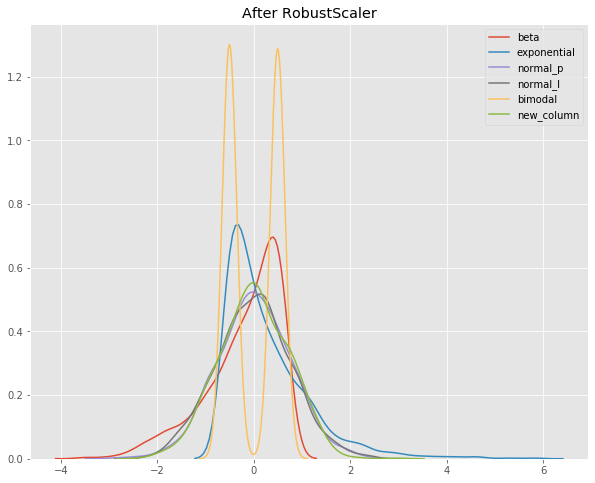

In [16]:
r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(df)

df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After RobustScaler')

sns.kdeplot(df_r['beta'], ax=ax1)
sns.kdeplot(df_r['exponential'], ax=ax1)
sns.kdeplot(df_r['normal_p'], ax=ax1)
sns.kdeplot(df_r['normal_l'], ax=ax1)
sns.kdeplot(df_r['bimodal'], ax=ax1)
sns.kdeplot(df_r['new_column'], ax=ax1);

Vi kollar igen min och max efteråt (OBS; jämför med originalet högst upp innan vi startar olika skalningsmetoder).

In [17]:
mins = [df_r[col].min() for col in df_r.columns]
mins

[-3.521256013025104,
 -0.6332678488395711,
 -2.91156392760608,
 -2.2889157521406003,
 -0.7257316470250651,
 -2.2626655321281044]

In [18]:
maxs = [df_r[col].max() for col in df_r.columns]
maxs

[0.700265390227522,
 5.810261462820452,
 2.3787055278781155,
 2.433017414912012,
 0.7023702913932945,
 2.9482173719311544]

Vad har hänt?

### StandardScaler

StandardScaler skalar varje kolumn till att ha 0 som medelvärde och standardavvikelsen 1 (förutsätter att data är normalfördelat (Gaussian), annars fungerar den dåligt)

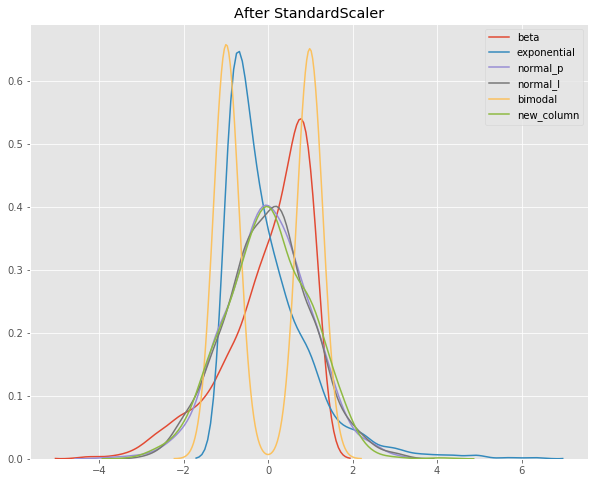

In [19]:
s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(df)

df_s = pd.DataFrame(df_s, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After StandardScaler')

sns.kdeplot(df_s['beta'], ax=ax1)
sns.kdeplot(df_s['exponential'], ax=ax1)
sns.kdeplot(df_s['normal_p'], ax=ax1)
sns.kdeplot(df_s['normal_l'], ax=ax1)
sns.kdeplot(df_s['bimodal'], ax=ax1)
sns.kdeplot(df_s['new_column'], ax=ax1);

Vi kontrollerar min och max efter skalningen återigen

In [20]:
mins = [df_s[col].min() for col in df_s.columns]
mins

[-4.270238356986723,
 -1.0299834064894655,
 -3.7939883106225425,
 -2.9424568517799368,
 -1.4206429830609901,
 -3.126779701794258]

In [21]:
maxs = [df_s[col].max() for col in df_s.columns]
maxs

[1.1766269856411702,
 6.302351061844018,
 3.0901485502210164,
 3.158463886242835,
 1.4055370928053141,
 4.070121916594157]

Vad har hänt? I jämförelse med de två innan?

# Normalizer

Normaliser transformerar rader istället för kolumner genom att (default) beräkna den Euclidiska normen som är roten ur summan av roten ur samtliga värden. Kallas för l2.

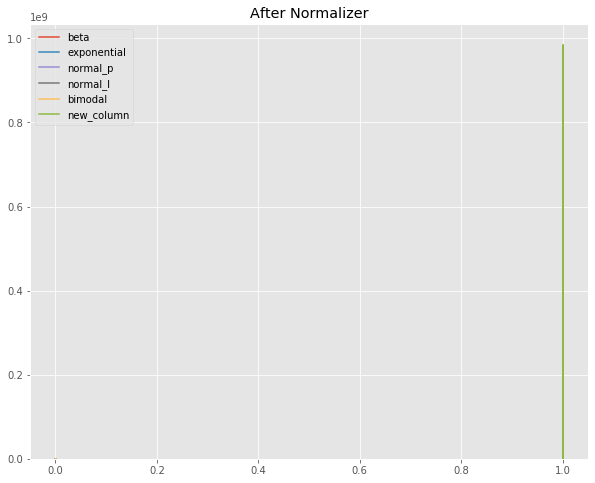

In [22]:
n_scaler = preprocessing.Normalizer()
df_n = n_scaler.fit_transform(df)

df_n = pd.DataFrame(df_n, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After Normalizer')

sns.kdeplot(df_n['beta'], ax=ax1)
sns.kdeplot(df_n['exponential'], ax=ax1)
sns.kdeplot(df_n['normal_p'], ax=ax1)
sns.kdeplot(df_n['normal_l'], ax=ax1)
sns.kdeplot(df_n['bimodal'], ax=ax1)
sns.kdeplot(df_n['new_column'], ax=ax1);

Min och max efter skalning

In [23]:
mins = [df_n[col].min() for col in df_n.columns]
mins

[1.3827732328245718e-05,
 7.506766221580962e-09,
 2.3413976491231327e-06,
 -1.9569177313577106e-05,
 -2.8641556621580004e-05,
 0.9999999959175602]

In [24]:
maxs = [df_n[col].max() for col in df_n.columns]
maxs

[6.0917225507124665e-05,
 7.142164283270129e-05,
 1.6544412294111953e-05,
 4.190267415662595e-05,
 2.8265467956698925e-05,
 0.9999999995621566]

Vad har hänt?

Nu tar vi en titt på alla olika sätt att skala tillsammans, dock skippar vi normalizern då det är ovanligt att man vill skala om rader.

### Kombinerad plot

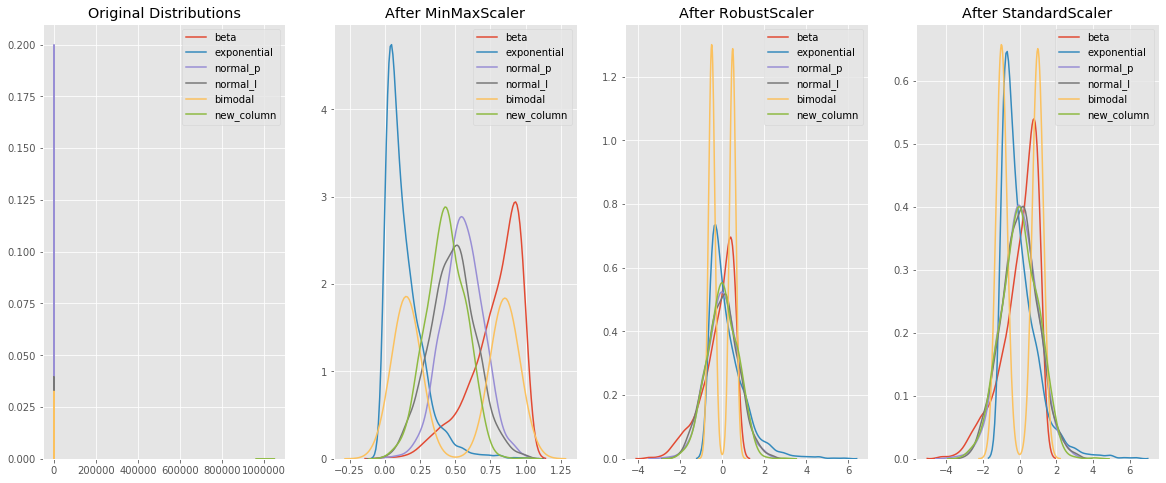

In [23]:
#Själva figuren
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20, 8))


ax0.set_title('Original Distributions')

sns.kdeplot(df['beta'], ax=ax0)
sns.kdeplot(df['exponential'], ax=ax0)
sns.kdeplot(df['normal_p'], ax=ax0)
sns.kdeplot(df['normal_l'], ax=ax0)
sns.kdeplot(df['bimodal'], ax=ax0)
sns.kdeplot(df['new_column'], ax=ax0);


ax1.set_title('After MinMaxScaler')

sns.kdeplot(df_mm['beta'], ax=ax1)
sns.kdeplot(df_mm['exponential'], ax=ax1)
sns.kdeplot(df_mm['normal_p'], ax=ax1)
sns.kdeplot(df_mm['normal_l'], ax=ax1)
sns.kdeplot(df_mm['bimodal'], ax=ax1)
sns.kdeplot(df_mm['new_column'], ax=ax1);


ax2.set_title('After RobustScaler')

sns.kdeplot(df_r['beta'], ax=ax2)
sns.kdeplot(df_r['exponential'], ax=ax2)
sns.kdeplot(df_r['normal_p'], ax=ax2)
sns.kdeplot(df_r['normal_l'], ax=ax2)
sns.kdeplot(df_r['bimodal'], ax=ax2)
sns.kdeplot(df_r['new_column'], ax=ax2);


ax3.set_title('After StandardScaler')

sns.kdeplot(df_s['beta'], ax=ax3)
sns.kdeplot(df_s['exponential'], ax=ax3)
sns.kdeplot(df_s['normal_p'], ax=ax3)
sns.kdeplot(df_s['normal_l'], ax=ax3)
sns.kdeplot(df_s['bimodal'], ax=ax3)
sns.kdeplot(df_s['new_column'], ax=ax3);

Efter samtliga transformationer är värdena på en mer lika skala. MinMax hade varit att föredra här eftersom den ger minst förskjutning av värdena i förhållande till varandra. Det är samma avstånd som i originalet, de andra två skalningsmetoderna ändrar avstånden mellan värdena vilket kommer påverka modellens korrekthet. 